## 12. 3.5 전자농도의 계산

### How to find $n(x,y,z)$


In [1]:
import numpy as np
from scipy.constants import e, m_e, h, k, epsilon_0, pi
from scipy.sparse import lil_matrix
from scipy.linalg import eigh

# Constants
q = e
m0 = m_e
hbar = h / (2 * pi)
T = 300
e_si = 11.7
e_ox = 3.9
nint = 1.075e16  # 1/m^3
thermal = k * T / q
e0 = epsilon_0

# Device parameters
width = 5e-9
tox = 0.8e-9
N = 67
dz = (width + 2 * tox) / (N - 1)
interface1 = round(tox / dz)
interface2 = round((tox + width) / dz)
N1 = interface2 - interface1 - 1
Na = 1e24
Lx = 100e-9
Ly = 100e-9
nmax = N1

coeff = dz * dz * q / e0

Electron = np.zeros((N, 11))
Nz = np.zeros((N, 11))

phi = np.full(N, 0.33374)

for index_Vg in range(11):
    Vg = index_Vg * 0.1
    for _ in range(40):
        Jaco = lil_matrix((N, N))
        res = np.zeros(N)

        for ii in range(N):
            if ii == 0 or ii == N - 1:
                res[ii] = phi[ii] - 0.33374 - Vg
                Jaco[ii, ii] = 1
            elif interface1 < ii < interface2:
                res[ii] = e_si * (phi[ii-1] - 2 * phi[ii] + phi[ii+1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal))
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -2 * e_si - coeff * nint * np.exp(phi[ii] / thermal) / thermal
                Jaco[ii, ii-1] = e_si
            elif ii < interface1 or ii > interface2:
                res[ii] = e_ox * (phi[ii-1] - 2 * phi[ii] + phi[ii+1])
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -2 * e_ox
                Jaco[ii, ii-1] = e_ox
            elif ii == interface1:
                res[ii] = e_si * (-phi[ii] + phi[ii+1]) - e_ox * (phi[ii] - phi[ii-1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii+1] = e_si
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii-1] = e_ox
            elif ii == interface2:
                res[ii] = e_ox * (-phi[ii] + phi[ii+1]) - e_si * (phi[ii] - phi[ii-1]) + coeff * (-Na - nint * np.exp(phi[ii] / thermal)) / 2
                Jaco[ii, ii+1] = e_ox
                Jaco[ii, ii] = -e_si - e_ox - coeff * nint * np.exp(phi[ii] / thermal) / (2 * thermal)
                Jaco[ii, ii-1] = e_si

        delphi = np.linalg.solve(Jaco.toarray(), -res)
        phi += delphi

        if np.max(np.abs(delphi)) < 1e-15:
            break

    Elec_save = nint * np.exp(phi / thermal) / 1e6
    Electron[interface1:interface2, index_Vg] = Elec_save[interface1:interface2]

    V = -q * phi + 0.56 * q
    Elec_valley = np.zeros((N1, 3))

    for valley_type in range(3):
        if valley_type == 0:
            mzz, mxx, myy = 0.91 * m0, 0.19 * m0, 0.19 * m0
        elif valley_type == 1:
            mzz, mxx, myy = 0.19 * m0, 0.91 * m0, 0.19 * m0
        else:
            mzz, mxx, myy = 0.19 * m0, 0.19 * m0, 0.91 * m0
        md = np.sqrt(mxx * myy)

        ham = np.zeros((N1, N1))
        for a in range(N1):
            V_local = V[interface1 + 1 + a]
            ham[a, a] = -2 - 2 * mzz * dz * dz * V_local / hbar**2
            if a > 0:
                ham[a, a - 1] = 1
            if a < N1 - 1:
                ham[a, a + 1] = 1

        eigvals, eigvecs = eigh(ham)
        Ezn = np.sort(eigvals / (-2 * mzz * dz * dz) * hbar**2)
        sorted_vecs = eigvecs[:, np.argsort(eigvals)]

        normalize = np.zeros_like(sorted_vecs)
        for n in range(N1):
            dist = sorted_vecs[:, n] ** 2
            normalize[:, n] = dist / (np.sum(dist) * dz)

        for z in range(N1):
            for n in range(nmax):
                Ez = Ezn[n]
                sub = Lx * Ly / (2 * pi) * md / hbar**2 * k * T * np.log(1 + np.exp(-Ez / (k * T)))
                Elec_valley[z, valley_type] += normalize[z, n] * sub / (Lx * Ly)

    Nz[interface1+1:interface2, index_Vg] = 4 * np.sum(Elec_valley, axis=1) / 1e6

eDensity_Poisson = Electron
eDensity_Schrodinger = Nz


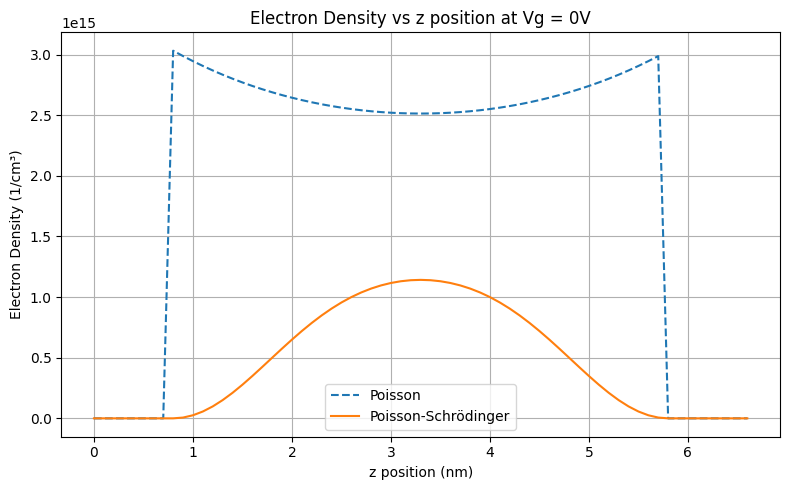

In [4]:
import matplotlib.pyplot as plt

# z 위치 배열 생성
z = np.linspace(0, width + 2 * tox, N) * 1e9  # nm 단위로 변환

# Vg = 0V일 때의 인덱스는 0
poisson_density = eDensity_Poisson[:, 0]
schrodinger_density = eDensity_Schrodinger[:, 0]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(z, poisson_density, label='Poisson', linestyle='--')
plt.plot(z, schrodinger_density, label='Poisson-Schrödinger', linestyle='-')
plt.xlabel('z position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs z position at Vg = 0V')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


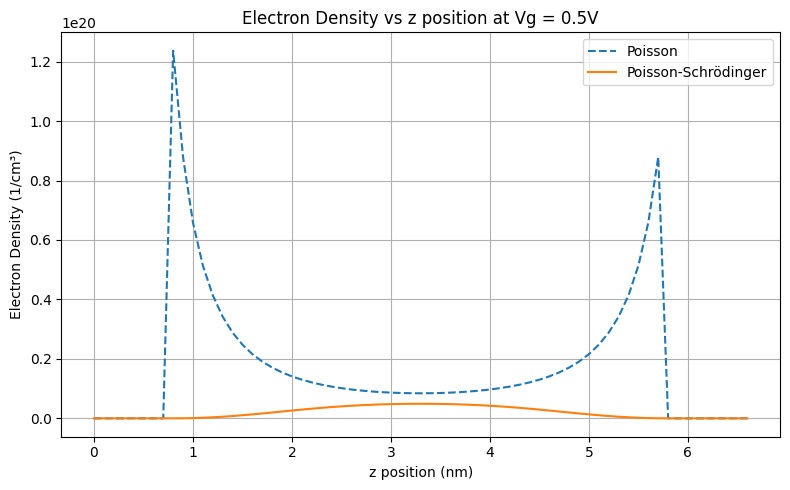

In [5]:
import matplotlib.pyplot as plt

# z 위치 배열 생성 (단위: nm)
z = np.linspace(0, width + 2 * tox, N) * 1e9  # meter → nm

# Vg = 0.5V에 해당하는 인덱스는 5 (0.1V 단위로 증가했으므로)
index_Vg = 5
poisson_density = eDensity_Poisson[:, index_Vg]
schrodinger_density = eDensity_Schrodinger[:, index_Vg]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(z, poisson_density, label='Poisson', linestyle='--')
plt.plot(z, schrodinger_density, label='Poisson-Schrödinger', linestyle='-')
plt.xlabel('z position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs z position at Vg = 0.5V')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


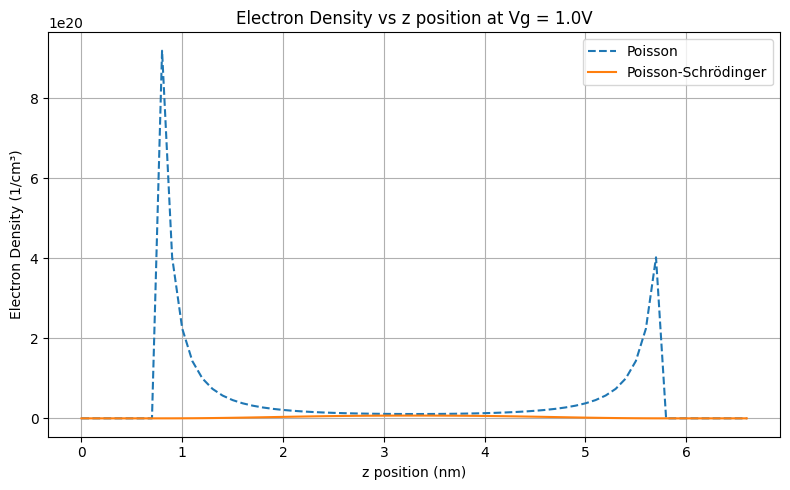

In [7]:
import matplotlib.pyplot as plt

# z 위치 배열 생성 (단위: nm)
z = np.linspace(0, width + 2 * tox, N) * 1e9  # meter → nm

# Vg = 0.5V에 해당하는 인덱스는 5 (0.1V 단위로 증가했으므로)
index_Vg = 10
poisson_density = eDensity_Poisson[:, index_Vg]
schrodinger_density = eDensity_Schrodinger[:, index_Vg]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(z, poisson_density, label='Poisson', linestyle='--')
plt.plot(z, schrodinger_density, label='Poisson-Schrödinger', linestyle='-')
plt.xlabel('z position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs z position at Vg = 1.0V')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


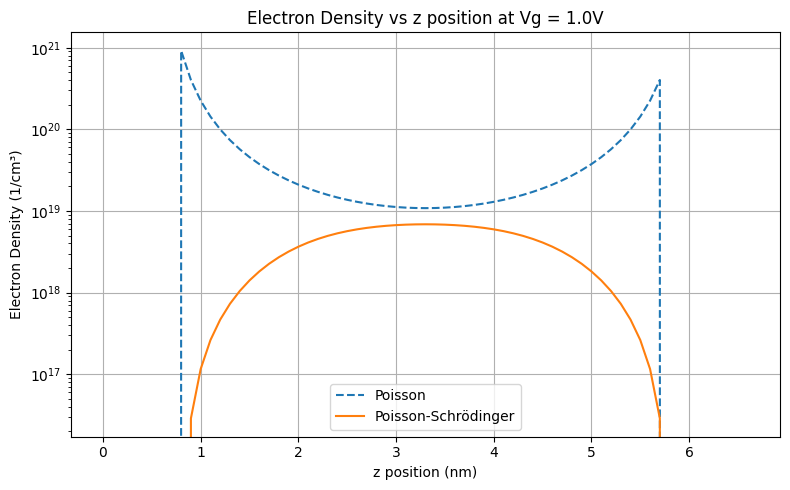

In [8]:
import matplotlib.pyplot as plt

# z 위치 배열 생성 (단위: nm)
z = np.linspace(0, width + 2 * tox, N) * 1e9  # meter → nm

# Vg = 0.5V에 해당하는 인덱스는 5 (0.1V 단위로 증가했으므로)
index_Vg = 10
poisson_density = eDensity_Poisson[:, index_Vg]
schrodinger_density = eDensity_Schrodinger[:, index_Vg]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.semilogy(z, poisson_density, label='Poisson', linestyle='--')
plt.semilogy(z, schrodinger_density, label='Poisson-Schrödinger', linestyle='-')
plt.xlabel('z position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs z position at Vg = 1.0V')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


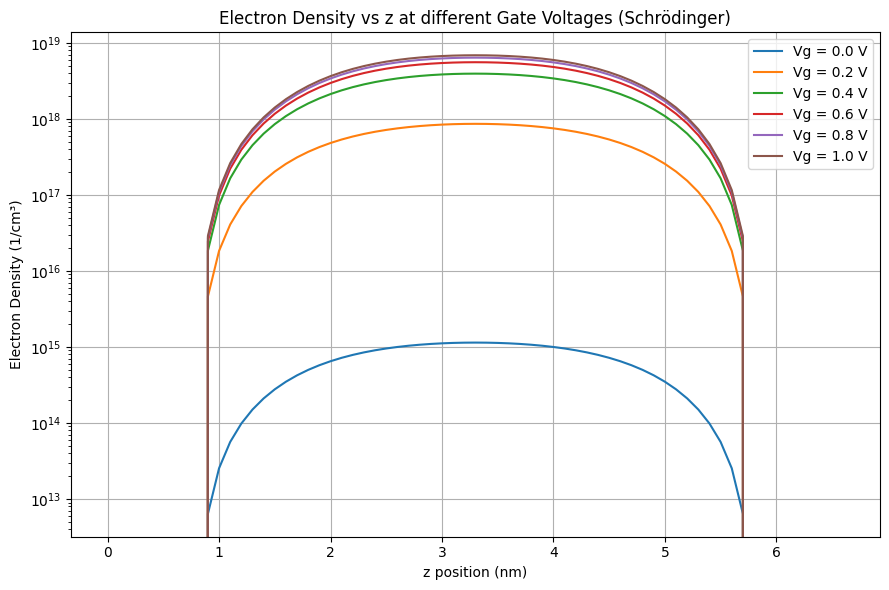

In [12]:
import matplotlib.pyplot as plt

# z 위치 배열 생성 (단위: nm)
z = np.linspace(0, width + 2 * tox, N) * 1e9  # m → nm

# 0V부터 1V까지 0.2V 간격 → index 0, 2, 4, 6, 8, 10
Vg_indices = list(range(0, 11, 2))  # index for 0.0V, 0.2V, ..., 1.0V
Vg_values = [i * 0.1 for i in Vg_indices]  # 실제 Vg 값 리스트

plt.figure(figsize=(9, 6))

# 각 전압에 대해 전자 밀도 플롯
for idx, Vg in zip(Vg_indices, Vg_values):
    plt.semilogy(z, eDensity_Schrodinger[:, idx], label=f'Vg = {Vg:.1f} V')

plt.xlabel('z position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs z at different Gate Voltages (Schrödinger)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


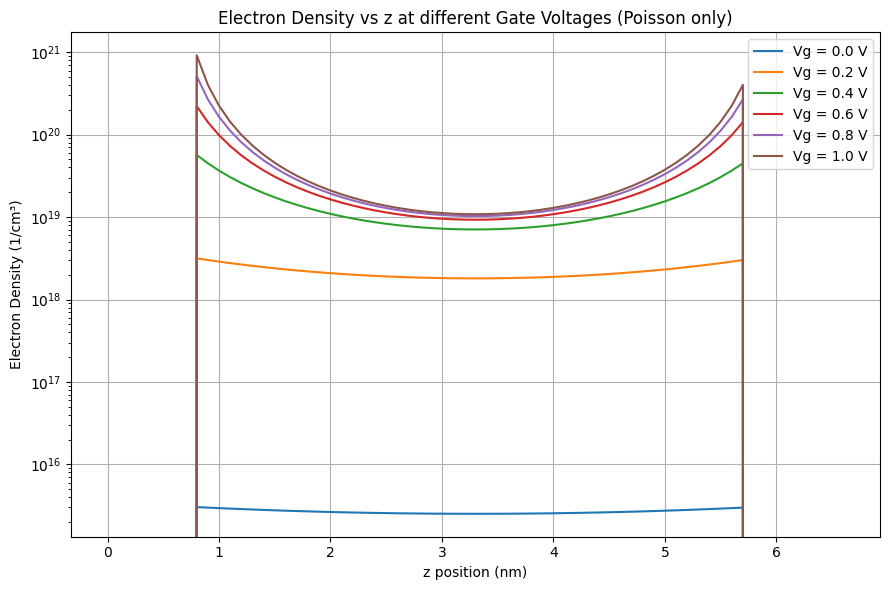

In [13]:
import matplotlib.pyplot as plt

# z 위치 배열 (단위: nm)
z = np.linspace(0, width + 2 * tox, N) * 1e9  # m → nm

# 0V부터 1V까지 0.2V 간격 인덱스 (0, 2, 4, 6, 8, 10)
Vg_indices = list(range(0, 11, 2))
Vg_values = [i * 0.1 for i in Vg_indices]

plt.figure(figsize=(9, 6))

# Poisson 계산 전자 농도 플롯
#for idx, Vg in zip(Vg_indices, Vg_values):
#    plt.plot(z, eDensity_Poisson[:, idx], label=f'Vg = {Vg:.1f} V')

for i in Vg_indices:
    Vg = i * 0.1
    plt.semilogy(z, eDensity_Poisson[:, i], label=f'Vg = {Vg:.1f} V')

plt.xlabel('z position (nm)')
plt.ylabel('Electron Density (1/cm³)')
plt.title('Electron Density vs z at different Gate Voltages (Poisson only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1.0000000000017133
3.89389532832185e-05
1.0000000000017057


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_11064\1192612953.py:121: RuntimeWarning: overflow encountered in exp
  density = 2*np.sum((psi**2)/((1+np.exp(E/kT))*Lx*Ly),axis=1)


7.84894371719247e-12
1.0000000000017089
0.0
1.0000000000017089
1.0000000000020586
0.001754876981956477
1.0000000000017075
1.6397003255175235e-08
1.0000000000017057
1.5271117703719028e-13
1.0000000000017064
0.0
1.0000000000017064
1.0000000000075187
0.030577005351524522
1.0000000000017069
8.286459391992906e-06
1.0000000000017082
3.5786175134333575e-09
1.0000000000017086
1.5449863610683678e-12
1.0000000000017102
1.9984014443252818e-15
1.0000000000017102
0.0
1.0000000000017102
1.0000000000191502
0.10506180962727185
1.0000000000017082
0.0002966768502358219
1.00000000000177
1.6785936961527526e-06
1.000000000001768
9.48949085977091e-09
1.000000000001768
5.364575450528264e-11
1.0000000000017666
3.0309088572266774e-13
1.0000000000017668
9.992007221626409e-16
1.0000000000017686
1.0000000000300244
0.1955933008594729
1.0000000000017097
0.0006116879226737426
1.000000000001832
5.254137986909768e-07
1.00000000000183
4.570197553732669e-10
1.0000000000018316
3.9823699893304365e-13
1.00000000000183
0.0


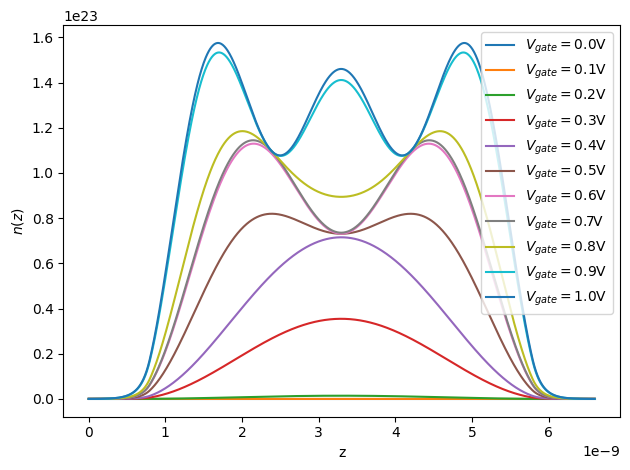

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
import scipy.linalg as slin
import scipy.integrate as inte
import fractions

#np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

Nc = 2.86*1e+25
#kT = 25.85*1e-3
kT = sc.k*300
ni = Nc*np.exp(-0.56*sc.e/kT)
N = 1000
Nacc = 1e+24
q = sc.e 
e1 = 3.9*sc.epsilon_0
e2 = 11.7*sc.epsilon_0
deltax = ((6.6*1e-9)/(N-1))
Lx = 1e-7
Ly = 1e-7
mzz = 0.19*sc.m_e

inter2 = int((N-1)*(5.8/6.6))
inter1 = int((N-1)*(0.8/6.6))
thermal = kT/q

itr = 20 
centerphi = np.zeros(itr)
def density_phi_cl(gate):
    p_density=np.zeros(N)
    e_density=np.zeros(N)
    density=np.zeros(N)
    phi = np.full(N,0.33374)
    #for i in range(itr) :
    GV = (gate)/10.0
    centerphi = 1000
    diff = 1000
    while diff>1e-5 :
        centerphi = phi[int(N/2)]
        e_density = ni*np.exp(q*phi/kT)
        e_density[:inter1] = 0
        e_density[inter2+1:] = 0

        #p_density = ni*np.exp(-q*phi/kT)
        #p_density[:inter1] = 0
        #p_density[inter2+1:] = 0
 
        density = 2*ni*np.sinh(q*phi/kT)
        density[:inter1] = 0
        density[inter2+1:] = 0

        H = np.zeros((N,N))
        np.fill_diagonal(H,-2*e1)
        np.fill_diagonal(H[1:],e1)
        np.fill_diagonal(H[:,1:],e1)

        np.fill_diagonal(H[0:inter2+1],-2*e2)
        np.fill_diagonal(H[1:inter2+1],e2)
        np.fill_diagonal(H[:,1:inter2+1],e2)
        H[inter2][inter2] = (-e2-e1)

        np.fill_diagonal(H[0:inter1+1],-2*e1)
        np.fill_diagonal(H[1:inter1+1],e1)
        np.fill_diagonal(H[:,1:inter1+1],e1)
        H[inter1][inter1] = (-e2-e1)

        H[0][0] = 1
        H[0][1] = 0
        H[N-1][N-1] = 1
        H[N-1][N-2] = 0

        B = np.zeros(N)
        B[inter1] = q*(Nacc+density[inter1])/2.0
        B[inter1+1:inter2] = q*(Nacc+density[inter1+1:inter2])
        B[inter2] = q*(Nacc+density[inter2])/2.0
        B = B*deltax*deltax
        B[0] = 0.33374 + GV
        B[N-1] = 0.33374 + GV

        res = np.zeros(N)
        res = np.matmul(H,phi) - B

        der_B = np.zeros((N,N))
        np.fill_diagonal(der_B[inter1:inter2,inter1:inter2],2*q*(q/kT)*ni*np.cosh(q*phi[inter1:inter2]/kT))
        der_B[inter1,inter1] = (q/kT)*q*ni*np.cosh(q*phi[inter1]/kT)
        der_B[inter2,inter2] = (q/kT)*q*ni*np.cosh(q*phi[inter2]/kT)

        der_B = der_B*deltax*deltax

        Jaco = np.zeros((N,N))
        Jaco = H - der_B
        
        phi=phi + slin.solve(Jaco,-res)

        diff = abs(phi[int(N/2)]-centerphi)
    x = np.linspace(0,6.6*1e-9,num=N,endpoint=True)
    #plt.plot(x, density,label=r'$V_{gate}=$'+str(GV)+'V',c=plt.cm.cool(gate/11),marker='o',lw=0,ms=10)
    return density,phi

def density_cooking(phi) :
	bandgap_si = 1.11
	bandgap_o = 8.9

	H = np.zeros((N-2,N-2))
	np.fill_diagonal(H,sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_o/2.0)
	np.fill_diagonal(H[:inter2-1],sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_si/2.0)
	np.fill_diagonal(H[:inter1-1],sc.hbar*sc.hbar/(mzz*deltax*deltax)-q*phi+q*bandgap_o/2.0)
	np.fill_diagonal(H[1:],-sc.hbar*sc.hbar/(2*mzz*deltax*deltax))
	np.fill_diagonal(H[:,1:],-sc.hbar*sc.hbar/(2*mzz*deltax*deltax))

	E,psi = slin.eigh(H)
	psi = psi/np.sqrt(deltax)
	psi = np.concatenate((np.zeros((1,N-2)),psi),axis=0)
	psi = np.concatenate((psi,np.zeros((1,N-2))),axis=0)

	#intagrating ground state -> should be 1.
	z = np.linspace(0,6.6*1e-9,N,endpoint=True)
	print(inte.simpson(psi[:,0]**2,x=z))

	density = 2*np.sum((psi**2)/((1+np.exp(E/kT))*Lx*Ly),axis=1)
	return density

def density_phi_qm(gate,density,phi):
    GV = (gate)/10.0
    diff = 1000
    centerphi = 1000
    while diff>1e-15:
        centerphi = phi[int(N/2)]
        H = np.zeros((N,N))
        np.fill_diagonal(H,-2*e1)
        np.fill_diagonal(H[1:],e1)
        np.fill_diagonal(H[:,1:],e1)

        np.fill_diagonal(H[0:inter2+1],-2*e2)
        np.fill_diagonal(H[1:inter2+1],e2)
        np.fill_diagonal(H[:,1:inter2+1],e2)
        H[inter2][inter2] = (-e2-e1)

        np.fill_diagonal(H[0:inter1+1],-2*e1)
        np.fill_diagonal(H[1:inter1+1],e1)
        np.fill_diagonal(H[:,1:inter1+1],e1)
        H[inter1][inter1] = (-e2-e1)

        H[0][0] = 1
        H[0][1] = 0
        H[N-1][N-1] = 1
        H[N-1][N-2] = 0

        B = np.zeros(N)
        B[inter1] = q*(Nacc+density[inter1])/2.0
        B[inter1+1:inter2] = q*(Nacc+density[inter1+1:inter2])
        B[inter2] = q*(Nacc+density[inter2])/2.0
        B = B*deltax*deltax
        B[0] = 0.33374 + GV
        B[N-1] = 0.33374 + GV
        phi = slin.solve(H,B)
        diff = abs(phi[int(N/2)]-centerphi)
        print(diff)
        density = density_cooking(phi)
    x = np.linspace(0,6.6*1e-9,num=N,endpoint=True)
    plt.plot(x, density,label=r'$V_{gate}=$'+str(GV)+'V')
    return density,phi

for gate in range(11) :
    density, phi = density_phi_cl(gate)
    q_density = density_cooking(phi)
    q_density, phi = density_phi_qm(gate,q_density,phi)

    plt.xlabel("z")
    plt.ylabel(r"$n(z)$")
    plt.legend()
    #plt.yscale('symlog')
    plt.tick_params()
    plt.tight_layout()
    

plt.show()



<>:143: SyntaxWarning: invalid escape sequence '\p'
<>:143: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ppjm7\AppData\Local\Temp\ipykernel_11064\2598288866.py:143: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$|\psi_m(z)|^2$')


0.9999999999999983


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_11064\2598288866.py:99: RuntimeWarning: overflow encountered in exp
  return 1./(1.+np.exp(E/(const.k*T)))


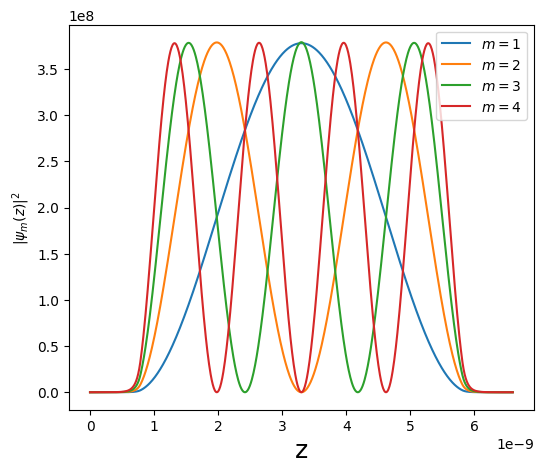

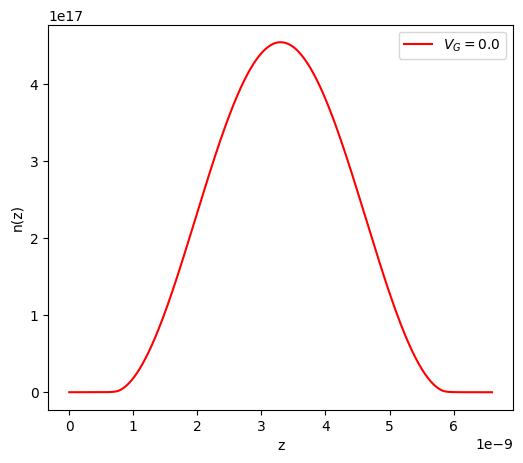

0.9999999999999978
0.9999999999999974
0.0008817681974752287
0.9999999999999997
1.1758267819894245e-10
0.999999999999998
0.9999999999999969
0.03976381505949092
0.9999999999999997
2.4621970726241243e-07
0.9999999999999976
1.625897298902023e-12
0.9999999999999984
0.9999999999999986
0.6992807969175493
0.9999999999999963
0.00012558039636953631
0.9999999999999997
3.843830768468254e-08
0.9999999999999967
0.9999999999999981
2.448998975198873
0.9999999999999969
0.005263498119449996
0.9999999999999972
2.8664032250142012e-05
0.9999999999999992
1.5600463321507704e-07
0.9999999999999967
8.490396652933696e-10
0.9999999999999957
0.9999999999999968
4.638672756143159
0.9999999999999992
0.013048327874250545
0.999999999999999
1.1150344556182304e-05
0.9999999999999978
9.588524412043921e-09
0.9999999999999993
0.9999999999999963
6.995678422196998
0.9999999999999961
0.017093916965950584
0.9999999999999986
6.993773599680925e-05
0.9999999999999976
2.8760837974200765e-07
0.9999999999999977
1.1830521734730596e-0

C:\Users\ppjm7\AppData\Local\Temp\ipykernel_11064\2598288866.py:174: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = axs[0].legend(loc='best',frameon=False)


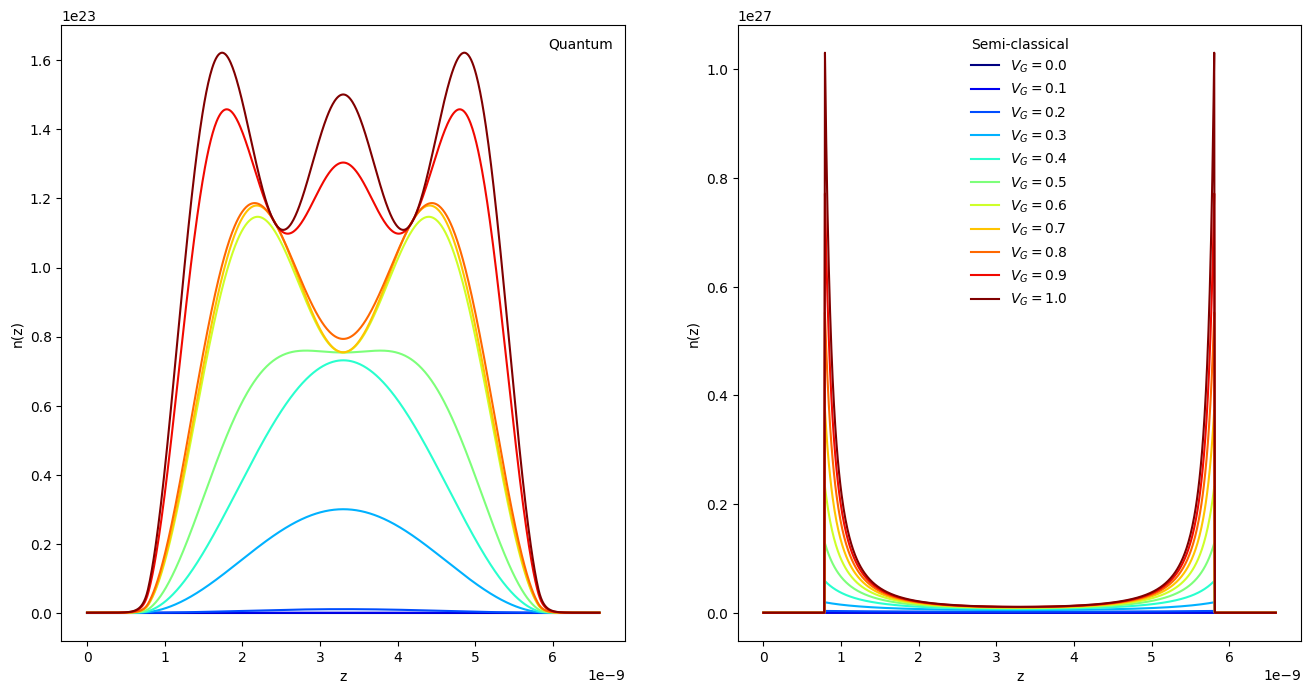

In [3]:
import numpy as np
from scipy.linalg import solve
from scipy.linalg import eigh
from scipy.integrate import simpson
import scipy.constants as const 
import matplotlib.pyplot as plt

N = 800
L = 6.6e-9
h = L/(N-1)
e1 = 3.9*const.epsilon_0
e2 = 11.7*const.epsilon_0
Nacc = 1e24
phi0 = 0.33374
T = 300.
ni = 2.86e25*np.exp(-const.e*0.56/(const.k*T))
M1 = int(N*8./66.)
M2 = int(N*58./66.)

mzz = 0.19*const.m_e
Lx = 100e-9
Ly = 100e-9

def make_mat():
    H = np.zeros((N,N))

    np.fill_diagonal(H[:M1,:],-2.*e1/h)
    np.fill_diagonal(H[1:M1,:],e1/h)
    np.fill_diagonal(H[:M1,1:],e1/h)

    H[M1,M1] = (-e1-e2)/h; H[M1,M1+1] = e2/h; H[M1,M1-1] = e1/h

    np.fill_diagonal(H[M1+1:,M1+1:],-2.*e2/h)
    np.fill_diagonal(H[M1+1:,M1+2:],e2/h)
    np.fill_diagonal(H[M1+1:,M1:],e2/h)

    H[M2,M2] = (-e2-e1)/h; H[M2,M2+1] = e1/h; H[M2,M2-1] = e2/h

    np.fill_diagonal(H[M2+1:,M2+1:],-2.*e1/h)
    np.fill_diagonal(H[M2+1:,M2+2:],e1/h)
    np.fill_diagonal(H[M2+1:,M2:],e1/h)

    H[0,0] = 1.; H[N-1,N-1] = 1.
    H[0,1] = 0.; H[N-1,N-2] = 0.
    
    return H

def make_b(Vg,phi,n=np.zeros(N),feedback_on=False):
    b = np.zeros(N)

    b[M1+1:M2] = const.e*Nacc*h
    b[M1] = const.e*Nacc*h/2.
    b[M2] = const.e*Nacc*h/2.

    if feedback_on :
        b += const.e*n*h
    else :
        b[M1+1:M2] += 2.*const.e*ni*np.sinh(const.e*phi[M1+1:M2]/(const.k*T))*h
        b[M1] += const.e*ni*np.sinh(const.e*phi[M1]/(const.k*T))*h
        b[M2] += const.e*ni*np.sinh(const.e*phi[M2]/(const.k*T))*h

    b[0] = phi0+Vg; b[N-1] = phi0+Vg

    return b

def make_db(phi):
    db = np.zeros((N,N))

    np.fill_diagonal(db[M1+1:M2,M1+1:M2],2.*const.e*ni*np.cosh(const.e*phi[M1+1:M2]/(const.k*T))*const.e/(const.k*T)*h)
    db[M1,M1] = const.e*ni*np.cosh(const.e*phi[M1]/(const.k*T))*const.e/(const.k*T)*h
    db[M2,M2] = const.e*ni*np.cosh(const.e*phi[M2]/(const.k*T))*const.e/(const.k*T)*h

    return db

def Newton(dx_list,phi_,Vg):
    H = make_mat()

    dx = 1.; phi = phi_
    while dx > 1e-7:
        r = np.matmul(H,phi)-make_b(Vg,phi)
        J = H-make_db(phi)
        dphi = solve(J,-r)
        phi += dphi
        dx = np.linalg.norm(dphi)
        dx_list.append(dx)

    return phi

def make_mat_Ham():
    H = np.zeros((N-2,N-2))

    np.fill_diagonal(H,-2.)
    np.fill_diagonal(H[1:],1)
    np.fill_diagonal(H[:,1:],1)

    return H/h

def FD_dist(E):
    return 1./(1.+np.exp(E/(const.k*T)))

def ele_density(phi):
    gap = np.full(N-2,4.5)
    gap[M1-1:M2] = 0.56

    mzz_list = np.full(N-2,0.58*const.m_e)
    mzz_list[M1-1:M2] = mzz

    Ham = make_mat_Ham()-2.*np.diag(mzz_list)*h/const.hbar**2*const.e*np.diag(gap-phi[1:N-1])
    E,V = eigh(-Ham*const.hbar**2/(2.*mzz*h))

    V = V*np.sqrt(1./h)
    v0 = np.zeros((1,N-2))
    V = np.concatenate((v0,V),axis=0)
    V = np.concatenate((V,v0),axis=0)

    z = np.linspace(0,L,N)
    print(simpson(V[:,0]**2,x=z))

    n_list = np.sum(V**2*FD_dist(E),axis=1)

    return 2.*n_list/(Lx*Ly), V

def self_consistency(Vg,phi_,n_qn):
    dx = 1.
    while dx>1e-7:
        phi = solve(make_mat(),make_b(Vg,phi_,n_qn,True))
        n_qn,psi = ele_density(phi)
        dphi = phi-phi_; phi_ = phi
        dx = np.linalg.norm(dphi); print(dx)
    return n_qn

phi_ = np.full(N,phi0)
z = np.linspace(0,L,N)

plt.figure(figsize=(6,5))

Vg = 0.0
dx_list=[]
phi = Newton(dx_list,phi_,Vg)
n_qn,psi = ele_density(phi)

plt.xlabel('z',fontsize=18)
plt.ylabel('$|\psi_m(z)|^2$')
for i in range(4):
    plt.plot(z,psi[:,i]**2,label='$m=$'+str(i+1))
plt.legend(loc='best')

plt.show()

plt.figure(figsize=(6,5))

plt.xlabel('z')
plt.ylabel('n(z)')
plt.plot(z,n_qn,'r-',label='$V_G=$'+str(Vg))
plt.legend(loc='best')

plt.show()

fig,axs = plt.subplots(1,2,figsize=(16,8))

for Vg in np.linspace(0,1,11):
    dx_list=[]
    phi = Newton(dx_list,phi_,Vg)
    n_qn,psi = ele_density(phi)
    n_cl = np.zeros(N); n_cl[M1:M2+1] =  ni*np.exp(const.e*phi[M1:M2+1]/(const.k*T))
    
    n_qn = self_consistency(Vg,phi,n_qn)

    axs[0].plot(z,n_qn,c=plt.cm.jet(Vg))
    axs[1].plot(z,n_cl,c=plt.cm.jet(Vg),label='$V_G=$'+str(format(Vg,'1.1f')))

axs[0].set_xlabel('z')
axs[0].set_ylabel('n(z)')
legend = axs[0].legend(loc='best',frameon=False)
legend.set_title('Quantum')

axs[1].set_xlabel('z')
axs[1].set_ylabel('n(z)')
legend = axs[1].legend(loc='best',frameon=False)
legend.set_title('Semi-classical')

plt.show()

